In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import matplotlib.pyplot as plt  # for plotting graphs
from datetime import datetime  #for following date-time operations 
import numpy as np         # for mathematical calculations
import pandas as pd     # for data manipulation
from statsmodels.tsa.arima.model import ARIMA #for ARIMA model
import statsmodels.api as sm        # for statistical models
from sklearn.metrics import mean_absolute_error # for evaluating models
from statsmodels.tsa.holtwinters import ExponentialSmoothing        # for Holt-Winters Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing      # for Simple Exponential Smoothing
from statsmodels.tsa.seasonal import seasonal_decompose     # for seasonal decomposition
import statsmodels.tsa.api as smt       # for statistical tests
from statsforecast import StatsForecast  #for importing all model
from statsforecast.models import HoltWinters  #choosing Holt-Winters from the imported models
import warnings     # for ignoring warnings
warnings.filterwarnings('ignore')

C:\Users\aniru\anaconda3\Lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df_2021_2022 = pd.read_csv("Demand_data_2021_2022.csv", parse_dates=['DEMAND_TIME'])
df_2022_2023 = pd.read_csv("Demand_Forecast_2022_2023.csv", parse_dates=['DEMAND_TIME'])
del df_2021_2022['SUB_COMMODITY']

In [3]:
df = pd.concat([df_2021_2022, df_2022_2023])
df.shape

(296727, 7)

In [4]:
df.head()

,DEMAND_IS,DEMAND_TIME,DEMAND_MET_DATE,STTNFROM,COMMODITY,NUMBER_OF_WAGONS,STTNTO
0,NKCR51/28102021,2021-10-28 16:16:00,NaN,SEC/BSP/NKCR,COAL,59,SEC/BSP/KHS
1,OKSR9/29082021,2021-08-29 17:09:00,2021-08-29 18:10:00.000,SEC/BSP/OKSR,COAL,59,SEC/BSP/KHS
2,SSCK9/21102021,2021-10-21 18:20:00,2023-03-12 19:23:00.000,EC/DHN/SSCK,COAL,60,NE/BSB/IAA
3,BKSC1/25032022,2022-03-25 12:51:00,2022-03-28 22:41:00.000,SE/ADRA/BKSC,COAL,59,NE/BSB/IAA
4,SSCK11/22102021,2021-10-22 17:45:00,2023-05-31 19:51:00.000,EC/DHN/SSCK,COAL,59,NE/LJN/KEA


In [5]:
df.isnull().sum()

DEMAND_IS              0
DEMAND_TIME            0
DEMAND_MET_DATE     8703
STTNFROM               0
COMMODITY              0
NUMBER_OF_WAGONS       0
STTNTO                 0
dtype: int64

In [6]:
del df['DEMAND_MET_DATE']

In [7]:
df.isnull().sum()

DEMAND_IS           0
DEMAND_TIME         0
STTNFROM            0
COMMODITY           0
NUMBER_OF_WAGONS    0
STTNTO              0
dtype: int64

In [8]:
type(df['DEMAND_TIME'].head()[0])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
df['yyyy_mm_dd'] = df['DEMAND_TIME'].dt.strftime('%Y-%m-%d')
df['yyyy_mm_dd'] = [datetime.strptime(i,"%Y-%m-%d") for i in df['yyyy_mm_dd']]

In [11]:
def find_stn(stn):
    n = len(stn)
    if stn[n-2] == '/':
          return stn[n-1:n]
    elif stn[n-3] == '/':
          return stn[n-2:n]
    elif stn[n-4] == '/':
          return stn[n-3:n]
    else:
          return stn[n-4:n]

In [12]:
df['STTNFROM'] = df.STTNFROM.apply(find_stn)

In [13]:
df['STTNTO'] = df.STTNTO.apply(find_stn)

In [14]:
df.head()

,DEMAND_IS,DEMAND_TIME,STTNFROM,COMMODITY,NUMBER_OF_WAGONS,STTNTO,yyyy_mm_dd
0,NKCR51/28102021,2021-10-28 16:16:00,NKCR,COAL,59,KHS,2021-10-28
1,OKSR9/29082021,2021-08-29 17:09:00,OKSR,COAL,59,KHS,2021-08-29
2,SSCK9/21102021,2021-10-21 18:20:00,SSCK,COAL,60,IAA,2021-10-21
3,BKSC1/25032022,2022-03-25 12:51:00,BKSC,COAL,59,IAA,2022-03-25
4,SSCK11/22102021,2021-10-22 17:45:00,SSCK,COAL,59,KEA,2021-10-22


In [15]:
df['location'] = df['STTNFROM'].astype(str) + df['STTNTO'].astype(str)

In [16]:
df[df.location == 'MCLKMAVB']

,DEMAND_IS,DEMAND_TIME,STTNFROM,COMMODITY,NUMBER_OF_WAGONS,STTNTO,yyyy_mm_dd,location
4919,MCLK1/13092021,2021-09-13 11:10:00,MCLK,COAL,61,MAVB,2021-09-13,MCLKMAVB
4920,MCLK1/14092021,2021-09-14 10:39:00,MCLK,COAL,60,MAVB,2021-09-14,MCLKMAVB
4921,MCLK10/23022022,2022-02-23 13:47:00,MCLK,COAL,61,MAVB,2022-02-23,MCLKMAVB
4922,MCLK10/27082021,2021-08-27 11:38:00,MCLK,COAL,59,MAVB,2021-08-27,MCLKMAVB
4923,MCLK10/29052022,2022-05-29 13:41:00,MCLK,COAL,61,MAVB,2022-05-29,MCLKMAVB
...,...,...,...,...,...,...,...,...
147192,MCLK18/28092022,2022-09-28 19:18:00,MCLK,COAL,0,MAVB,2022-09-28,MCLKMAVB
148878,MCLK16/24112022,2022-11-24 16:17:00,MCLK,COAL,0,MAVB,2022-11-24,MCLKMAVB
148879,MCLK17/24112022,2022-11-24 16:17:00,MCLK,COAL,0,MAVB,2022-11-24,MCLKMAVB
148880,MCLK18/24112022,2022-11-24 16:18:00,MCLK,COAL,0,MAVB,2022-11-24,MCLKMAVB


In [17]:
df.sort_values('yyyy_mm_dd', inplace = True)

In [18]:
del df['DEMAND_TIME']
del df['DEMAND_IS']
del df['STTNFROM']
del df['STTNTO']
del df['COMMODITY']

In [19]:
df.head()

,NUMBER_OF_WAGONS,yyyy_mm_dd,location
61854,73,2021-08-01,PMCSMTPS
113213,59,2021-08-01,BCMTSTDV
32460,59,2021-08-01,LMGTMNKT
84508,59,2021-08-01,SBKTDSTP
21963,59,2021-08-01,SBCTSTDV


In [20]:
[r,c] = df.shape
r,c

(296727, 3)

In [21]:
df = df.groupby(['yyyy_mm_dd', 'location'], as_index=False)['NUMBER_OF_WAGONS'].sum()
df = df.rename(columns={'yyyy_mm_dd': 'ds','location': 'unique_id', 'NUMBER_OF_WAGONS': 'y'})

In [22]:
[n,m] = df.shape
n,m

(190492, 3)

In [23]:
df.head()

,ds,unique_id,y
0,2021-08-01,ACTRHEBS,177
1,2021-08-01,ACTRMGBK,59
2,2021-08-01,ACTRPPAP,236
3,2021-08-01,ACTRSTDV,59
4,2021-08-01,ACTRTPAK,118


In [24]:
ids = df.unique_id.unique()

In [25]:
type(ids), len(ids), ids

(numpy.ndarray,
 6742,
 array(['ACTRHEBS', 'ACTRMGBK', 'ACTRPPAP', ..., 'JCZPSSS', 'LPGMBMB',
        'VAABSIM'], dtype=object))

In [32]:
df_fil = pd.DataFrame()
for i in ids:
    if len(df[df.unique_id == i]) >= 500:
        df_ = df[df['unique_id'] == i]
        df_fil = pd.concat([df_fil, df_])

In [33]:
df_fil

,ds,unique_id,y
2,2021-08-01,ACTRPPAP,236
112,2021-08-02,ACTRPPAP,177
261,2021-08-03,ACTRPPAP,177
475,2021-08-04,ACTRPPAP,59
704,2021-08-05,ACTRPPAP,177
...,...,...,...
189149,2023-08-28,GGDACSGJ,118
189433,2023-08-29,GGDACSGJ,120
189746,2023-08-30,GGDACSGJ,119
190011,2023-08-31,GGDACSGJ,119


In [34]:
len(df_fil.unique_id.unique())

26

In [35]:
df_fil.reset_index(drop = True, inplace = True)

In [36]:
df_fil.head()

,ds,unique_id,y
0,2021-08-01,ACTRPPAP,236
1,2021-08-02,ACTRPPAP,177
2,2021-08-03,ACTRPPAP,177
3,2021-08-04,ACTRPPAP,59
4,2021-08-05,ACTRPPAP,177


In [37]:
locations = df_fil.unique_id.unique()

In [38]:
type(locations), len(locations), locations

(numpy.ndarray,
 26,
 array(['ACTRPPAP', 'BSTCPPAP', 'GSGNTPG', 'HLSGNTPG', 'ICMLMCES',
        'KECMBTPK', 'LMGTMNKT', 'PMBGTSWS', 'PSBPNTKS', 'ROBCSGJ',
        'SSCKMTPS', 'VLXUME', 'WBPCPSPM', 'BBMTPPAP', 'HDCGTWS',
        'LSSTPPAP', 'PSBPFSTP', 'SBKTMTPS', 'UMSGPMAM', 'BNDGBTSS',
        'SBCTPPAP', 'PSRSPCMC', 'PSRSKPRJ', 'DCSNVSTP', 'BCMTPPAP',
        'GGDACSGJ'], dtype=object))

In [39]:
main_df = pd.DataFrame()
for loc in locations:
    df_del = df[df.unique_id == loc]
    del df_del['unique_id']
    df2 = df_del[df.unique_id == loc].resample('D', on='ds').mean().ffill().reset_index()
    df2['unique_id'] = loc
    main_df = pd.concat([main_df, df2])

In [40]:
main_df

,ds,y,unique_id
0,2021-08-01,236.0,ACTRPPAP
1,2021-08-02,177.0,ACTRPPAP
2,2021-08-03,177.0,ACTRPPAP
3,2021-08-04,59.0,ACTRPPAP
4,2021-08-05,177.0,ACTRPPAP
...,...,...,...
654,2023-08-28,118.0,GGDACSGJ
655,2023-08-29,120.0,GGDACSGJ
656,2023-08-30,119.0,GGDACSGJ
657,2023-08-31,119.0,GGDACSGJ


In [41]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model, period = 7)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

In [42]:
main_df.head()

,ds,y,unique_id
0,2021-08-01,236.0,ACTRPPAP
1,2021-08-02,177.0,ACTRPPAP
2,2021-08-03,177.0,ACTRPPAP
3,2021-08-04,59.0,ACTRPPAP
4,2021-08-05,177.0,ACTRPPAP


In [43]:
len(main_df.unique_id.unique())

26

In [79]:
data = main_df[main_df.unique_id == 'GGDACSGJ']
# Setting the demand time to datetime feature
data.set_index('ds', inplace=True)
# Ensure the data is sorted by date
data.sort_index(inplace=True)

In [80]:
data.head(), data.tail()

(               y unique_id
 ds                        
 2021-11-12  61.0  GGDACSGJ
 2021-11-13  61.0  GGDACSGJ
 2021-11-14  61.0  GGDACSGJ
 2021-11-15  61.0  GGDACSGJ
 2021-11-16  60.0  GGDACSGJ,
                 y unique_id
 ds                         
 2023-08-28  118.0  GGDACSGJ
 2023-08-29  120.0  GGDACSGJ
 2023-08-30  119.0  GGDACSGJ
 2023-08-31  119.0  GGDACSGJ
 2023-09-01  120.0  GGDACSGJ)

In [161]:
training_set = data.loc['2021-08-01':'2023-08-26', :]
plot_set = data.loc['2023-08-01':'2023-08-26', :]
test_set = data.loc['2023-08-26':, :]

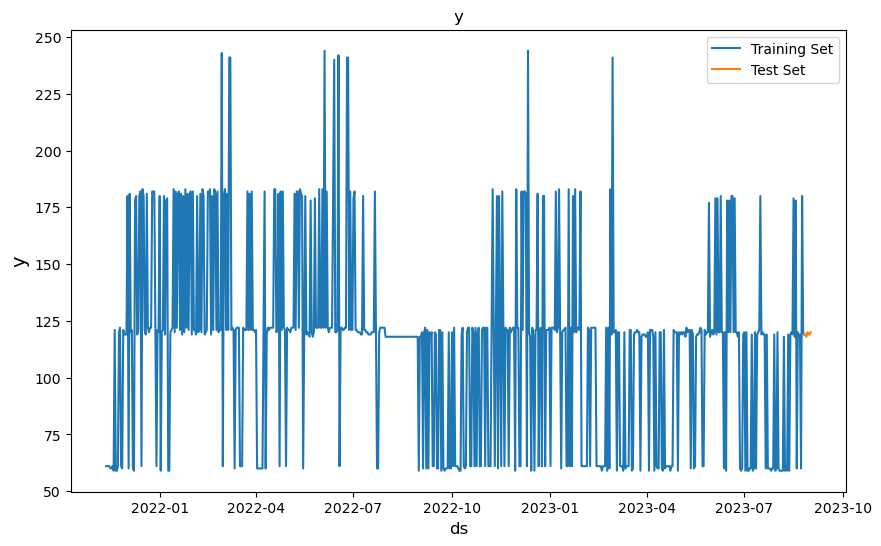

In [82]:
#Plotting the Number of Wagon
plt.figure(figsize=(10, 6))
plt.plot(training_set['y'], label='Training Set')
plt.plot(test_set['y'], label='Test Set')
plt.title('y')
plt.xlabel('ds', fontsize=12, verticalalignment='top')
plt.ylabel('y', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [83]:
#Stationarity test: ADF TEST
adf_test = st.adfuller(training_set['y'])
print(adf_test)

(-3.343697762151497, 0.013034653932160009, 17, 635, {'1%': -3.4406900498266193, '5%': -2.8661023102613137, '10%': -2.569199643499287}, 6399.451728369891)


In [84]:
# Fix seed for reproducible results
SEED = 42
np.random.seed(SEED)

# Visualizations
lag_acf = 15
lag_pacf = 15
height = 4
width = 12

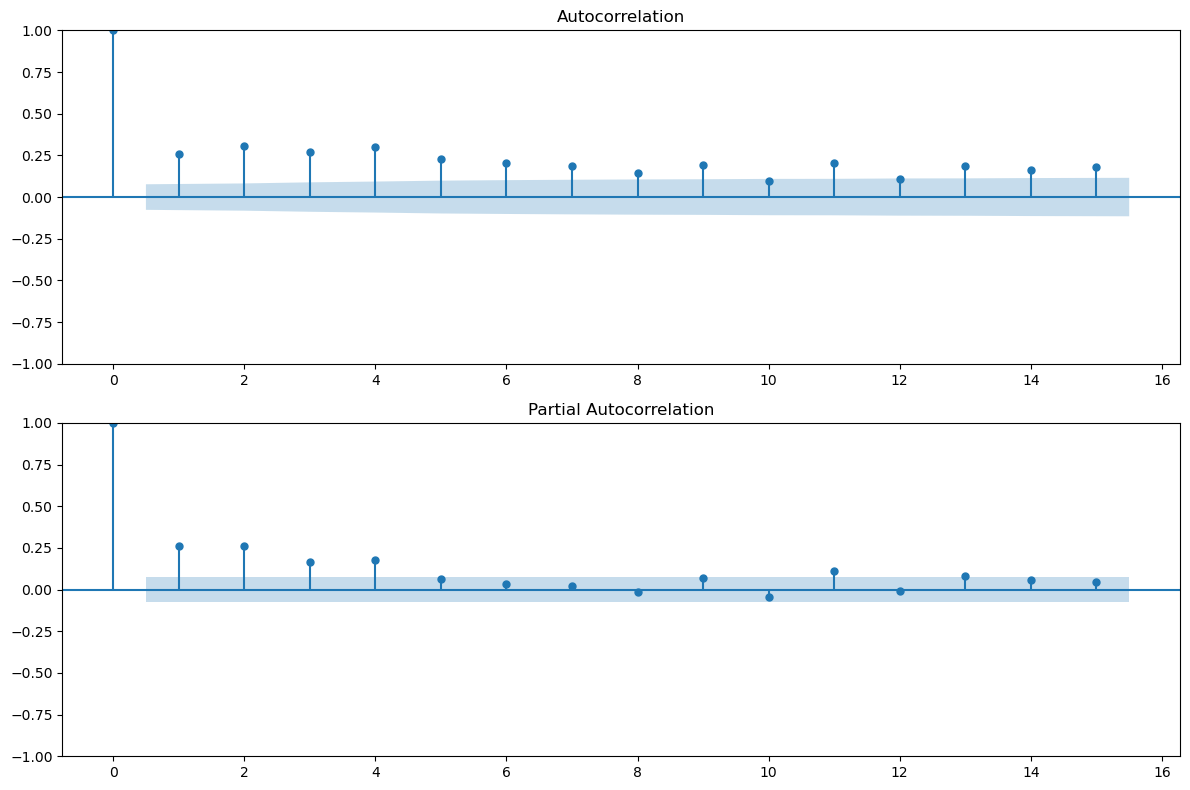

In [85]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(training_set['y'],lags=lag_acf, ax=ax[0])
plot_pacf(training_set['y'],lags=lag_pacf, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

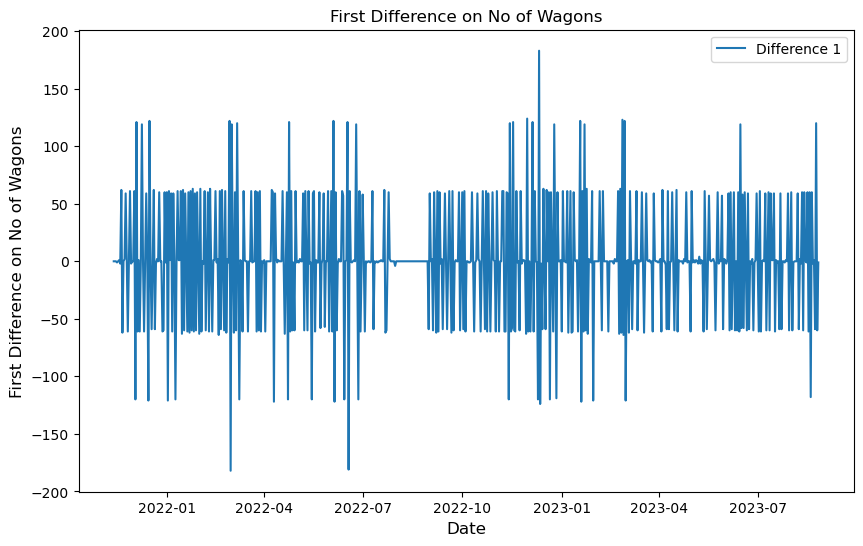

In [86]:
#Applying first Differencing
temp = np.array(training_set['y'])

training_set['diff1'] = training_set['y'].diff(1)
plt.figure(figsize=(10, 6))
plt.plot(training_set['diff1'], label='Difference 1')
plt.title('First Difference on No of Wagons')
plt.xlabel('Date', fontsize=12, verticalalignment='top')
plt.ylabel('First Difference on No of Wagons', fontsize= 12, horizontalalignment='center')
plt.legend()
plt.show()

In [87]:
#Stationarity test: ADF TEST
training_set['diff1'] = training_set['diff1'].fillna(0)
adf_test = st.adfuller(training_set['diff1'])
print(adf_test)

(-10.150232879255896, 7.986856263037683e-18, 16, 636, {'1%': -3.4406737255613256, '5%': -2.866095119842903, '10%': -2.5691958123689727}, 6407.415646542027)


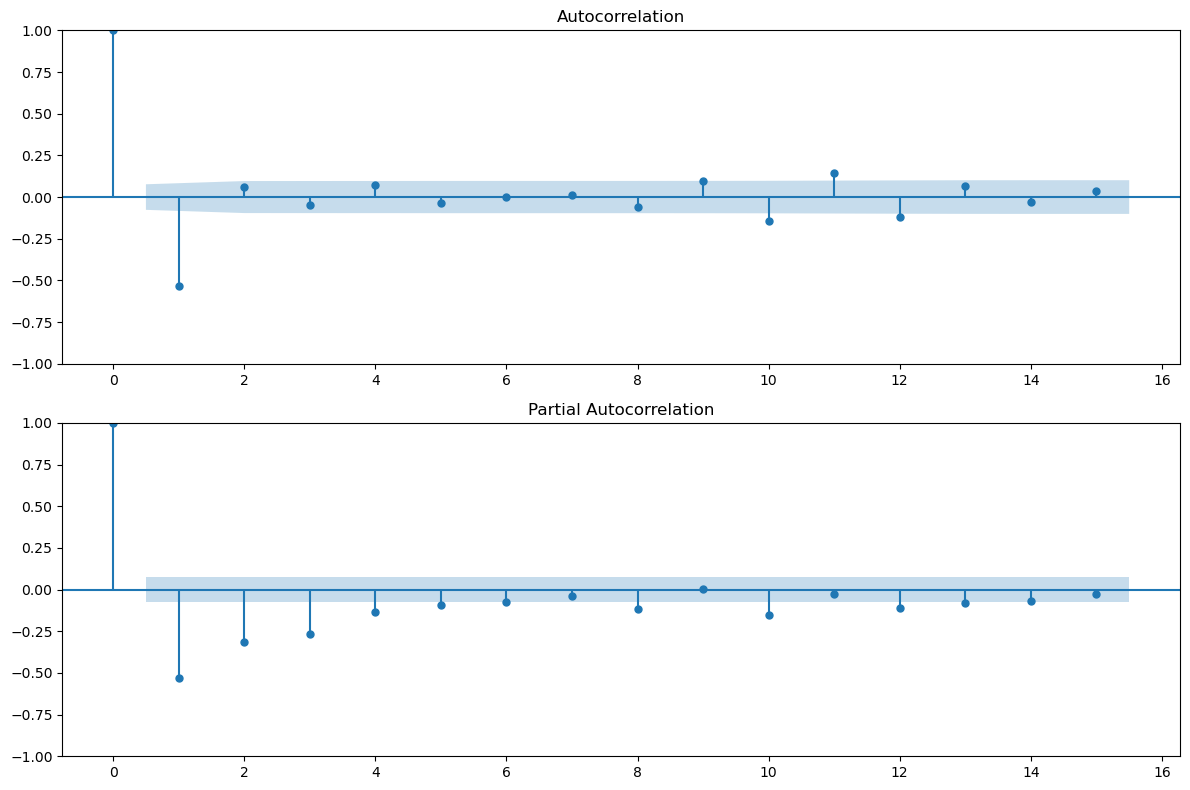

In [88]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(training_set['diff1'],lags=lag_acf, ax=ax[0])
plot_pacf(training_set['diff1'],lags=lag_pacf, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

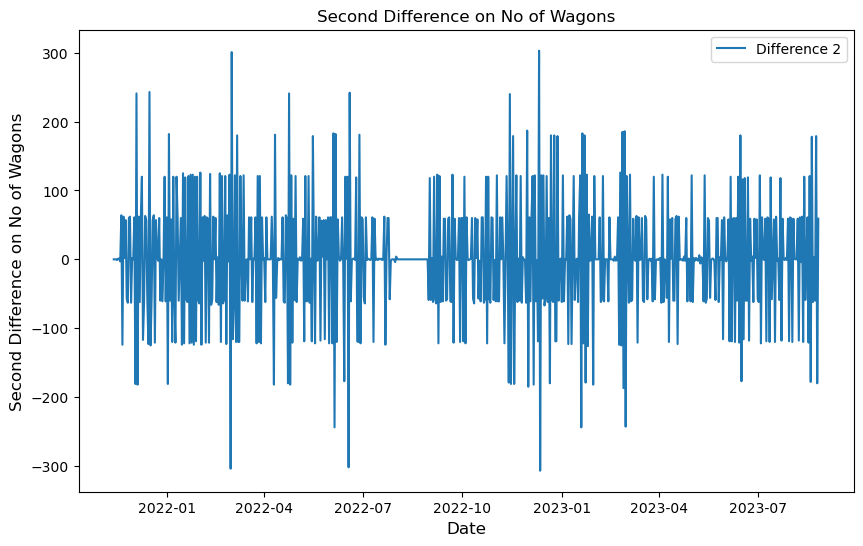

In [89]:
#Applying Second Differencing
temp = np.array(training_set['diff1'])

training_set['diff2'] = training_set['diff1'].diff(1)
plt.figure(figsize=(10, 6))
plt.plot(training_set['diff2'], label='Difference 2')
plt.title('Second Difference on No of Wagons')
plt.xlabel('Date', fontsize=12, verticalalignment='top')
plt.ylabel('Second Difference on No of Wagons', fontsize= 12, horizontalalignment='center')
plt.legend()
plt.show()

In [90]:
#Stationarity test: ADF TEST
training_set['diff2'] = training_set['diff2'].fillna(0)
adf_test = st.adfuller(training_set['diff2'])
print(adf_test)

(-12.061049502282238, 2.4689651298124768e-22, 19, 633, {'1%': -3.4407228537258865, '5%': -2.866116759417764, '10%': -2.5692073421780983}, 6486.831531296696)


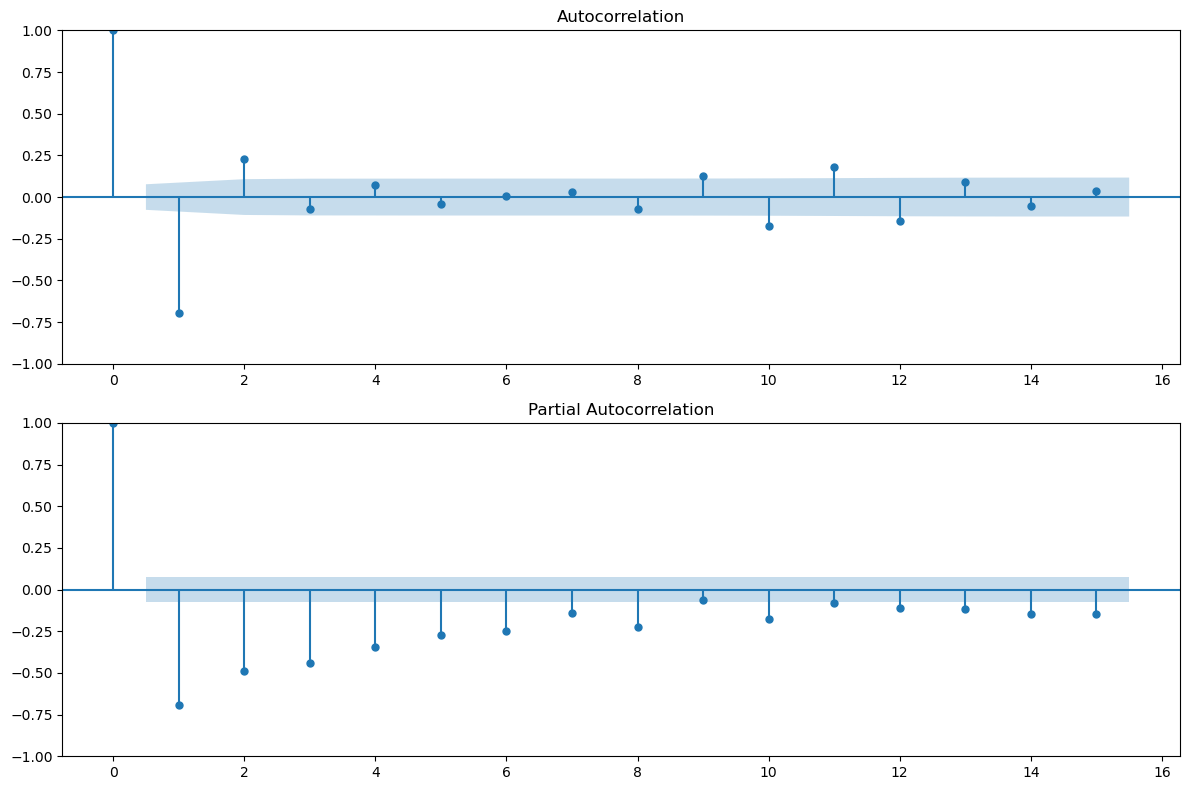

In [91]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(training_set['diff2'],lags=lag_acf, ax=ax[0])
plot_pacf(training_set['diff2'],lags=lag_pacf, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

In [92]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model, period = 7)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

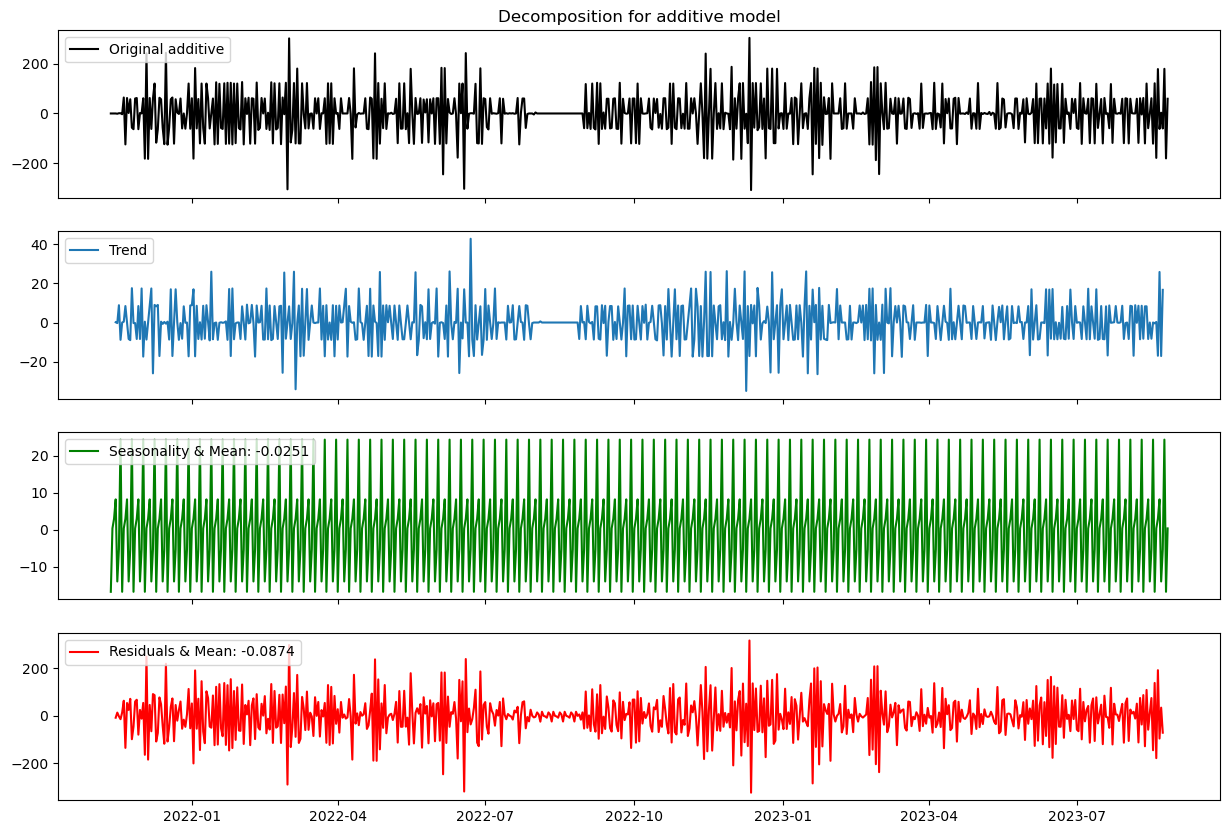

In [93]:
ts_decompose(training_set.diff2, stationary=True)

In [106]:
# Build SARIMA model
model = SARIMAX(training_set['y'], order=(2, 0, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()

# Forecast the next 7 days
forecast_steps = 7
forecast = results.get_forecast(steps=forecast_steps)

In [107]:
# Get the forecast values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [108]:
# Display the forecast values
print("Forecasted values for the next 7 days:")
print(forecast_values)

Forecasted values for the next 7 days:
2023-08-27    117.870845
2023-08-28    116.365098
2023-08-29    125.784089
2023-08-30    127.699782
2023-08-31    116.243589
2023-09-01    118.314165
2023-09-02    117.613291
Freq: D, Name: predicted_mean, dtype: float64


In [109]:
# Replace 'NUMBER_OF_WAGONS' and 'forecast_values' with actual column names
original_values = training_set['y'].values[:712]
forecasted_diff = forecast_values.values

#predicted_original_values = original_values[-1] + np.cumsum(forecasted_diff)
date_index = pd.date_range(start=training_set.index[-1] + pd.DateOffset(days=1), periods=len(forecasted_diff))
predicted_df = pd.DataFrame(data={'y': forecasted_diff}, index=date_index)
final_result = pd.concat([training_set[['y']], predicted_df])

# Print or use the final_result DataFrame as needed
print(final_result)

                     y
2021-11-12   61.000000
2021-11-13   61.000000
2021-11-14   61.000000
2021-11-15   61.000000
2021-11-16   60.000000
...                ...
2023-08-29  125.784089
2023-08-30  127.699782
2023-08-31  116.243589
2023-09-01  118.314165
2023-09-02  117.613291

[660 rows x 1 columns]


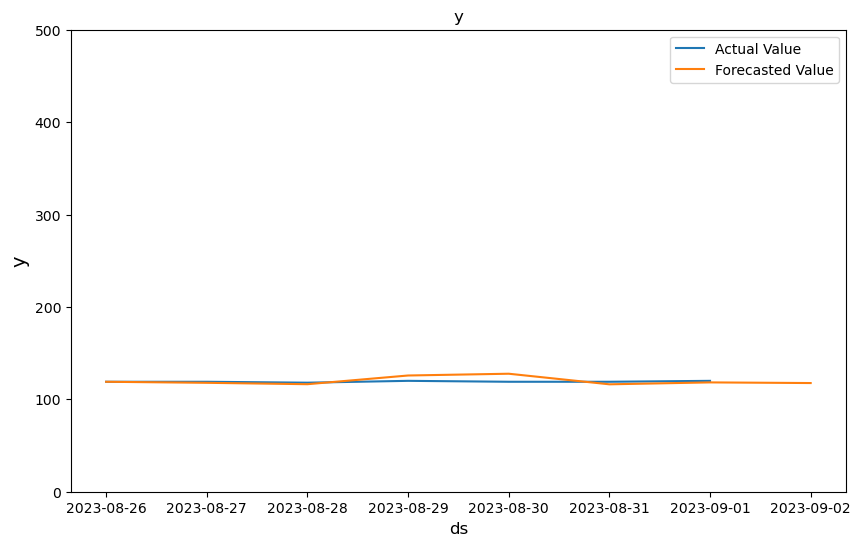

In [110]:
start_date = '2023-08-01'
end_date = '2023-08-26'

# Filter data for the specified date range
forec = final_result.loc[end_date:]

# Plotting the Number of Wagon for the specified date range
plt.figure(figsize=(10, 6))
plt.plot(test_set['y'], label='Actual Value')
plt.plot(forec['y'], label='Forecasted Value')
plt.title('y')
ax = plt.gca()
ax.set_ylim([0, 500])
plt.xlabel('ds', fontsize=12, verticalalignment='top')
plt.ylabel('y', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [112]:
error = np.array(test_set['y'] - forec['y'])
error = error[~np.isnan(error)]
mse = np.sum(error**2)
rmse = mse**0.5
rmse

11.114388650553176

In [181]:
split_date = datetime.strptime('2023-08-26', '%Y-%m-%d')

In [182]:
train = main_df.loc[main_df['ds'] < split_date]
test = main_df.loc[(main_df['ds'] >= split_date)]
h = test['ds'].nunique()

In [183]:
train

,ds,y,unique_id
0,2021-08-01,236.0,ACTRPPAP
1,2021-08-02,177.0,ACTRPPAP
2,2021-08-03,177.0,ACTRPPAP
3,2021-08-04,59.0,ACTRPPAP
4,2021-08-05,177.0,ACTRPPAP
...,...,...,...
647,2023-08-21,118.0,GGDACSGJ
648,2023-08-22,119.0,GGDACSGJ
649,2023-08-23,60.0,GGDACSGJ
650,2023-08-24,180.0,GGDACSGJ


In [184]:
test

,ds,y,unique_id
755,2023-08-26,476.0,ACTRPPAP
756,2023-08-27,476.0,ACTRPPAP
757,2023-08-28,182.0,ACTRPPAP
758,2023-08-29,301.0,ACTRPPAP
759,2023-08-30,181.0,ACTRPPAP
...,...,...,...
654,2023-08-28,118.0,GGDACSGJ
655,2023-08-29,120.0,GGDACSGJ
656,2023-08-30,119.0,GGDACSGJ
657,2023-08-31,119.0,GGDACSGJ


In [185]:
model = StatsForecast(models=[HoltWinters(season_length=7, error_type='A')], freq='D', n_jobs=-1)
model.fit(train)

StatsForecast(models=[HoltWinters])

In [195]:
z_90 = model.predict(h=h, level=[90])

In [196]:
z_95 = model.predict(h=h, level=[95])

In [197]:
p = z_90
p

,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90
unique_id,,,,
ACTRPPAP,2023-08-26,239.148697,5.538383,472.759003
ACTRPPAP,2023-08-27,248.988693,14.879531,483.097870
ACTRPPAP,2023-08-28,230.180756,-4.427715,464.789246
ACTRPPAP,2023-08-29,217.662445,-17.445807,452.770691
ACTRPPAP,2023-08-30,237.428268,1.819776,473.036743
...,...,...,...,...
WBPCPSPM,2023-08-28,86.258423,-77.595695,250.112549
WBPCPSPM,2023-08-29,107.717651,-59.576679,275.011993
WBPCPSPM,2023-08-30,110.810822,-59.857548,281.479187


In [198]:
arr = pd.to_datetime(p.ds)

In [199]:
arr[0]

Timestamp('2023-08-26 00:00:00')

In [200]:
p['ds'] = arr

In [201]:
p = p.reset_index().merge(test, on=['ds', 'unique_id'], how='inner')

In [202]:
p

,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,y
0,ACTRPPAP,2023-08-26,239.148697,5.538383,472.759003,476.0
1,ACTRPPAP,2023-08-27,248.988693,14.879531,483.097870,476.0
2,ACTRPPAP,2023-08-28,230.180756,-4.427715,464.789246,182.0
3,ACTRPPAP,2023-08-29,217.662445,-17.445807,452.770691,301.0
4,ACTRPPAP,2023-08-30,237.428268,1.819776,473.036743,181.0
...,...,...,...,...,...,...
153,WBPCPSPM,2023-08-28,86.258423,-77.595695,250.112549,177.0
154,WBPCPSPM,2023-08-29,107.717651,-59.576679,275.011993,177.0
155,WBPCPSPM,2023-08-30,110.810822,-59.857548,281.479187,177.0
156,WBPCPSPM,2023-08-31,97.488892,-76.491211,271.468994,118.0


In [208]:
error_hw = np.array(p.y - p.HoltWinters)
error_hw = error_hw[~np.isnan(error_hw)]
mse_hw = np.sum(error_hw**2)
rmse_hw = mse_hw**0.5
rmse_hw/26

42.558270040394625

In [209]:
p_indiv = p[p.unique_id == 'GGDACSGJ']

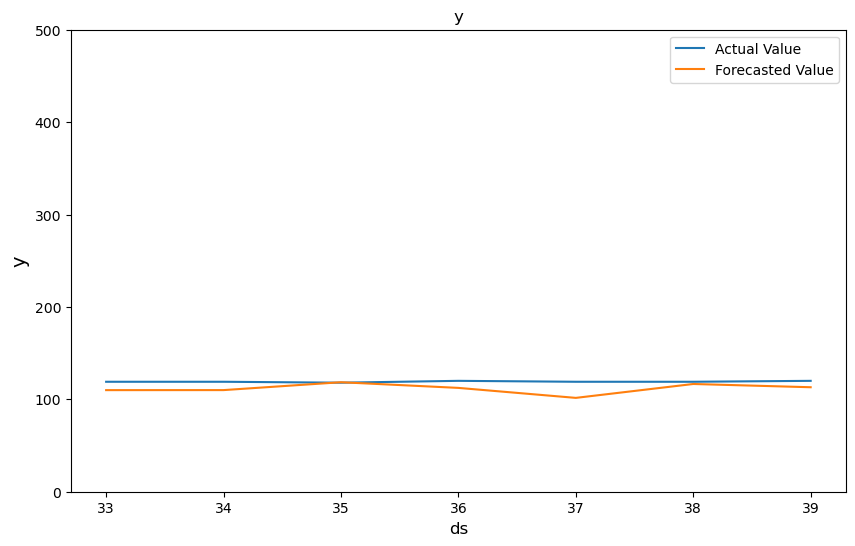

In [210]:
# Plotting the Number of Wagon for the specified date range
plt.figure(figsize=(10, 6))
plt.plot(p_indiv.y, label='Actual Value')
plt.plot(p_indiv.HoltWinters, label='Forecasted Value')
plt.title('y')
ax = plt.gca()
ax.set_ylim([0, 500])
plt.xlabel('ds', fontsize=12, verticalalignment='top')
plt.ylabel('y', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [211]:
error_hw_indiv = np.array(p_indiv.y - p_indiv.HoltWinters)
error_hw_indiv = error_hw_indiv[~np.isnan(error_hw_indiv)]
mse_hw_indiv = np.sum(error_hw_indiv**2)
rmse_hw_indiv = mse_hw_indiv**0.5
rmse_hw_indiv

24.07755561807828

In [214]:
loc_combined = main_df.unique_id.unique()
loc_combined

array(['ACTRPPAP', 'BSTCPPAP', 'GSGNTPG', 'HLSGNTPG', 'ICMLMCES',
       'KECMBTPK', 'LMGTMNKT', 'PMBGTSWS', 'PSBPNTKS', 'ROBCSGJ',
       'SSCKMTPS', 'VLXUME', 'WBPCPSPM', 'BBMTPPAP', 'HDCGTWS',
       'LSSTPPAP', 'PSBPFSTP', 'SBKTMTPS', 'UMSGPMAM', 'BNDGBTSS',
       'SBCTPPAP', 'PSRSPCMC', 'PSRSKPRJ', 'DCSNVSTP', 'BCMTPPAP',
       'GGDACSGJ'], dtype=object)

In [237]:
rmse = 0
rmse_matrix = []
loc_matrix = []
for loc in loc_combined:
    data = main_df[main_df.unique_id == loc]
    # Setting the demand time to datetime feature
    data.set_index('ds', inplace=True)
    # Ensure the data is sorted by date
    data.sort_index(inplace=True)
    training_set = data.loc['2021-08-01':'2023-08-26', :]
    plot_set = data.loc['2023-08-01':'2023-08-26', :]
    test_set = data.loc['2023-08-26':, :]
    # Build SARIMA model
    model = SARIMAX(training_set['y'], order=(2, 0, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit()

    # Forecast the next 7 days
    forecast_steps = 7
    forecast = results.get_forecast(steps=forecast_steps)
    
    # Replace 'NUMBER_OF_WAGONS' and 'forecast_values' with actual column names
    original_values = training_set['y'].values[:712]
    forecasted_diff = forecast_values.values

    #predicted_original_values = original_values[-1] + np.cumsum(forecasted_diff)
    date_index = pd.date_range(start=training_set.index[-1] + pd.DateOffset(days=1), periods=len(forecasted_diff))
    predicted_df = pd.DataFrame(data={'y': forecasted_diff}, index=date_index)
    final_result = pd.concat([training_set[['y']], predicted_df])
    
    start_date = '2023-08-01'
    end_date = '2023-08-26'

    # Filter data for the specified date range
    forec = final_result.loc[end_date:]
    error = np.array(test_set['y'] - forec['y'])
    error = error[~np.isnan(error)]
    mse = np.sum(error**2)
    rmse = mse**0.5
    rmse_matrix.append(rmse)

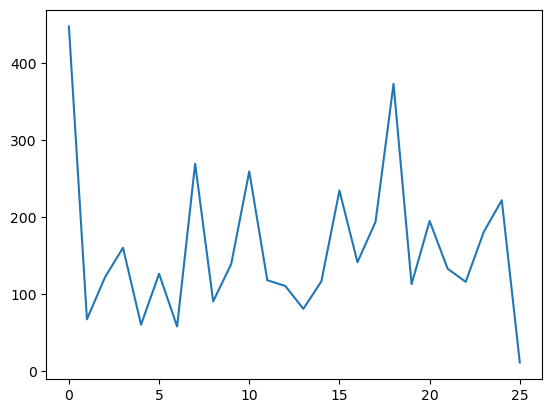

In [239]:
plt.plot(rmse_matrix)
plt.show()

In [241]:
rmse = sum(rmse_matrix)
rmse/26

159.09237987136572